<a href="https://colab.research.google.com/github/cmd-gunma-univ/DX-highschool/blob/main/YOLO_%E3%82%AB%E3%83%A9%E3%82%B9%E3%81%AE%E3%83%A2%E3%83%86%E3%82%99%E3%83%AB%E4%BD%9C%E3%82%8A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

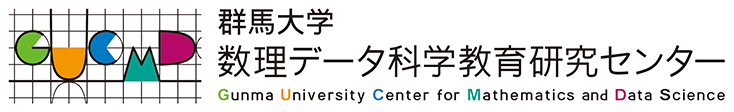

本デジタル教材の著作権は群馬大学数理データ科学教育研究センターに帰属します。

群馬大学出版会

Gunma University Press

TEL: 027-220-7180

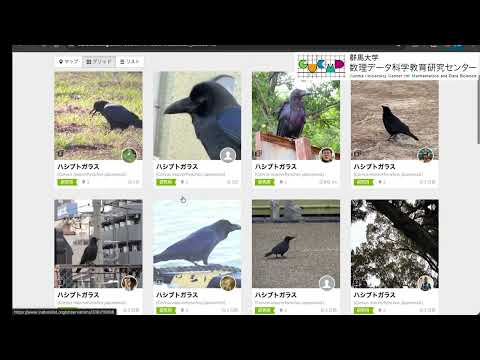

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("3mDNuOIn-t8", width=800, height=450)

# YOLOを使った固有物体の画像検出（「カラス」を例として）

---
## 「カラス」のデータベース作成
* まずはOpen Imagesなどに既に完成されたモデルがないかを探す
* モデルがない場合はネットからデータを集めて自分でモデルを作る
* ネットにデータがない場合はデータを自分で作る

## Open Imagesから探す
https://storage.googleapis.com/openimages/web/index.html  
Googleが公開している、世界最大級のオープンな画像データセット  

以下のリストから欲しいクラスがあるかどうかを確認  
Exploreから検索

Open Imagesには"crow"は存在しないことが分かった。

# 自分でデータベースを作る(ハシブトガラス)
以下で作るデータベースは[こちら](https://drive.google.com/file/d/1x_OyHyRzbymjuT7eeJZ58JU79kXXXZoG/view?usp=sharing)からダウンロードできます。

今回はiNaturalist(世界最大級の市民科学型・生物多様性データベース)を使用

* https://www.inaturalist.org/ で"Corvus macrorhynchos"(ハシブトガラス)を検索
* https://www.inaturalist.org/taxa/355745-Corvus-macrorhynchos-japonensis がデータ

以下でハシブトガラスの写真をダウンロード

In [ ]:
import requests
import os

os.makedirs("japonensis_images", exist_ok=True)

url = "https://api.inaturalist.org/v1/observations"
params = {
    "taxon_id": 355745, #ハシブトガラス（日本亜種）
    "quality_grade": "research", #研究品質の観察のみ取得
    "photos": True,
    "per_page": 200 #1リクエストあたりの最大件数(200が最大)
}

data = requests.get(url, params=params).json()

for obs in data["results"]:
    for photo in obs["photos"]:
        img_url = photo["url"].replace("square", "original")
        img_name = photo["id"]
        img = requests.get(img_url).content
        with open(f"japonensis_images/{img_name}.jpg", "wb") as f:
            f.write(img)

---
## Bounding boxの付与
https://www.makesense.ai/

In [ ]:
# 1つのファイルにまとめてダウンロード
! zip -r japonensis_images.zip japonensis_images

Make Senseを使ってBounding Boxをつけ終わった。  
japonesis_images/にBounding Boxの.txtを入れる  
フォルダを作る

In [ ]:
!mkdir -p crow_dataset/images/train
!mkdir -p crow_dataset/images/val
!mkdir -p crow_dataset/labels/train
!mkdir -p crow_dataset/labels/val

画像とtxtを分離して"train"に移す

In [ ]:
! mv japonensis_images/*.jpg crow_dataset/images/train/
! mv japonensis_images/*.txt crow_dataset/labels/train/

trainにある画像とtxtの20%を"valに移す"

In [ ]:
import os, random, shutil
from pathlib import Path

train_img_dir = Path("crow_dataset/images/train")
train_lbl_dir = Path("crow_dataset/labels/train")
val_img_dir   = Path("crow_dataset/images/val")
val_lbl_dir   = Path("crow_dataset/labels/val")

val_img_dir.mkdir(parents=True, exist_ok=True)
val_lbl_dir.mkdir(parents=True, exist_ok=True)

imgs = sorted([p for p in train_img_dir.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])
random.seed(42)

val_ratio = 0.2
n_val = max(1, int(len(imgs) * val_ratio))
val_imgs = random.sample(imgs, n_val)

moved = 0
skipped = 0

for img_path in val_imgs:
    lbl_path = train_lbl_dir / (img_path.stem + ".txt")

    # ラベルが無い画像はスキップ（YOLO形式として不整合なので）
    if not lbl_path.exists():
        skipped += 1
        continue

    shutil.move(str(img_path), str(val_img_dir / img_path.name))
    shutil.move(str(lbl_path), str(val_lbl_dir / lbl_path.name))
    moved += 1

print(f"Moved to val: {moved}  |  Skipped(no label): {skipped}")
print("train images:", len(list(train_img_dir.glob('*'))))
print("val images:", len(list(val_img_dir.glob('*'))))

Moved to val: 70  |  Skipped(no label): 1
train images: 286
val images: 70


dataset.yaml を作る
YOLOに対して以下の情報を伝える役割
* train / val / test の画像パス
* 何種類の物体を検出するか
* 各クラスIDの意味

In [ ]:
%%bash
cat << 'EOF' > crow_dataset/dataset.yaml
path: /home/pi/crow_dataset
train: images/train
val: images/val

names:
  0: crow
EOF

---
### 学習(epoch数=5回、RP5で20分くらいかかる。)


学習が終わると通常ここに出ます：
* runs/detect/crow_yolov8/weights/best.pt
* runs/detect/crow_yolov8/weights/last.pt

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # 軽量モデル（Raspberry Pi向き）

model.train(
    data="crow_dataset/dataset.yaml",
    epochs=5,
    imgsz=320,
    batch=1,
    name="crow_yolov8"
)

In [ ]:
from ultralytics import YOLO
import cv2
from IPython.display import display, Image, clear_output

model = YOLO("runs/detect/crow_yolov8/weights/best.pt")

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("カメラが開けませんでした。/dev/video0 を確認してください。")

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

frame_i = 0
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # 推論を軽く
        results = model(frame, imgsz=320, conf=0.25, verbose=False)[0]

        # crow(=class 0) の検出数
        crow_count = int((results.boxes.cls == 0).sum()) if results.boxes is not None else 0

        # 描画（重いのでNフレームに1回だけ）
        if frame_i % 5 == 0:
            annotated = results.plot()  # 重い
            cv2.putText(annotated, f"Crows: {crow_count}", (10, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

            ok, jpg = cv2.imencode(".jpg", annotated, [int(cv2.IMWRITE_JPEG_QUALITY), 70])
            if ok:
                clear_output(wait=True)
                display(Image(data=jpg.tobytes()))

        frame_i += 1

except KeyboardInterrupt:
    print("stop")

finally:
    cap.release()
    print("released")